In [24]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression, Lasso
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [2]:
os.chdir("/Users/shenchingfeng/GitHub/ML-Wine-Type-and-Quality-Classification")

In [3]:
r = 'data/tred.csv'
w = 'data/twhite.csv'

red = pd.read_csv(r).drop(columns = "Unnamed: 0")
white = pd.read_csv(w).drop(columns = "Unnamed: 0")

red['type'] = 1
white['type'] = 0

df = pd.concat([red, white])

In [29]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,0.965601,0.434520,-0.000000,0.434345,0.040250,2.715988,3.710526,0.9978,1.165072,0.206762,0.268966,5,1
1,0.972687,0.498508,-0.000000,0.454268,0.044648,3.662894,4.439253,0.9968,1.122948,0.217431,0.268972,5,1
2,0.972687,0.457142,0.038972,0.447288,0.043614,3.062287,4.205195,0.9970,1.131424,0.215122,0.268972,5,1
3,1.015099,0.224548,0.414036,0.434345,0.040006,3.206108,4.319267,0.9980,1.117205,0.208830,0.268972,6,1
4,0.965601,0.434520,-0.000000,0.434345,0.040250,2.715988,3.710526,0.9978,1.165072,0.206762,0.268966,5,1


In [30]:
df.to_csv("data/Wine.csv", index = False)

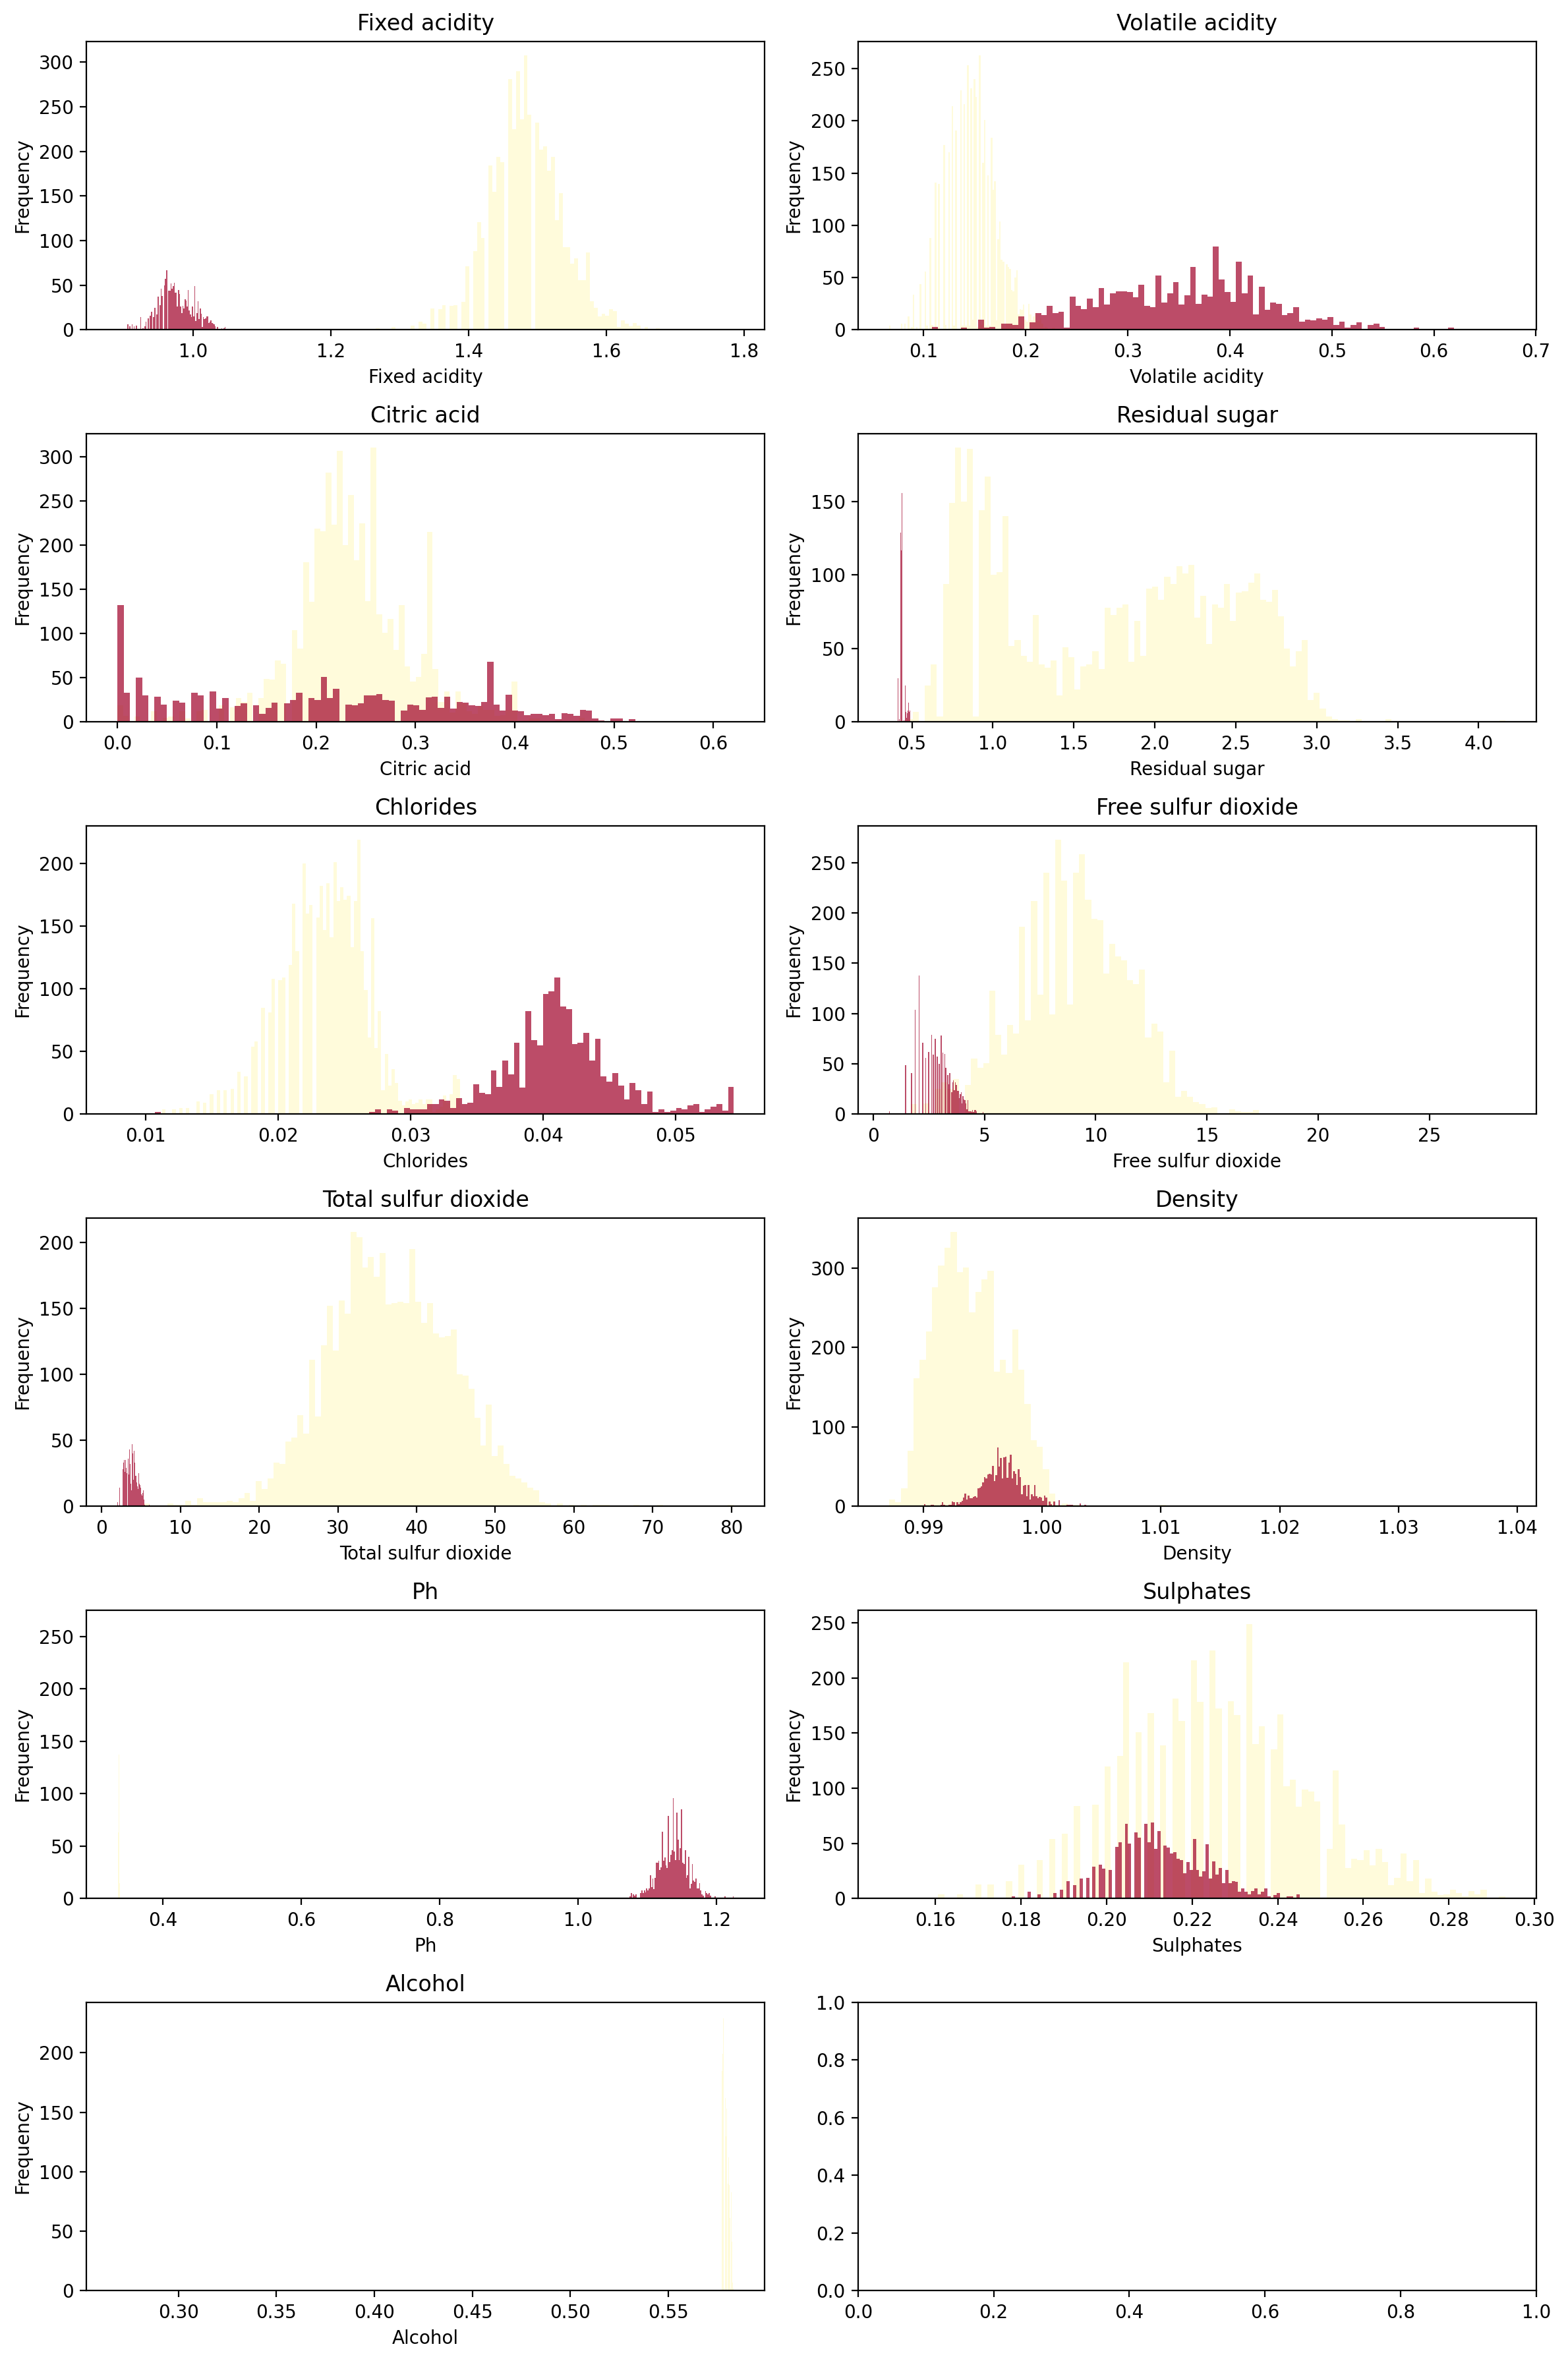

In [5]:
color_map = {0: '#fffacd', 1: '#a00028'}
col = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

fig, axs = plt.subplots(6, 2, figsize = (12, 18))

axs = axs.flatten()

for i, col in enumerate(col):

    axs[i].hist(white[col], color = color_map[0], bins = 100, alpha = 0.7, label = "White wine")
    axs[i].hist(red[col], color = color_map[1], bins = 100, alpha = 0.7, label = "Red wine")
    
    axs[i].set_xlabel(col.capitalize()) 
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'{col.capitalize()}')

plt.tight_layout()
plt.show()

## Multicollinearity

### Correlation coefficient

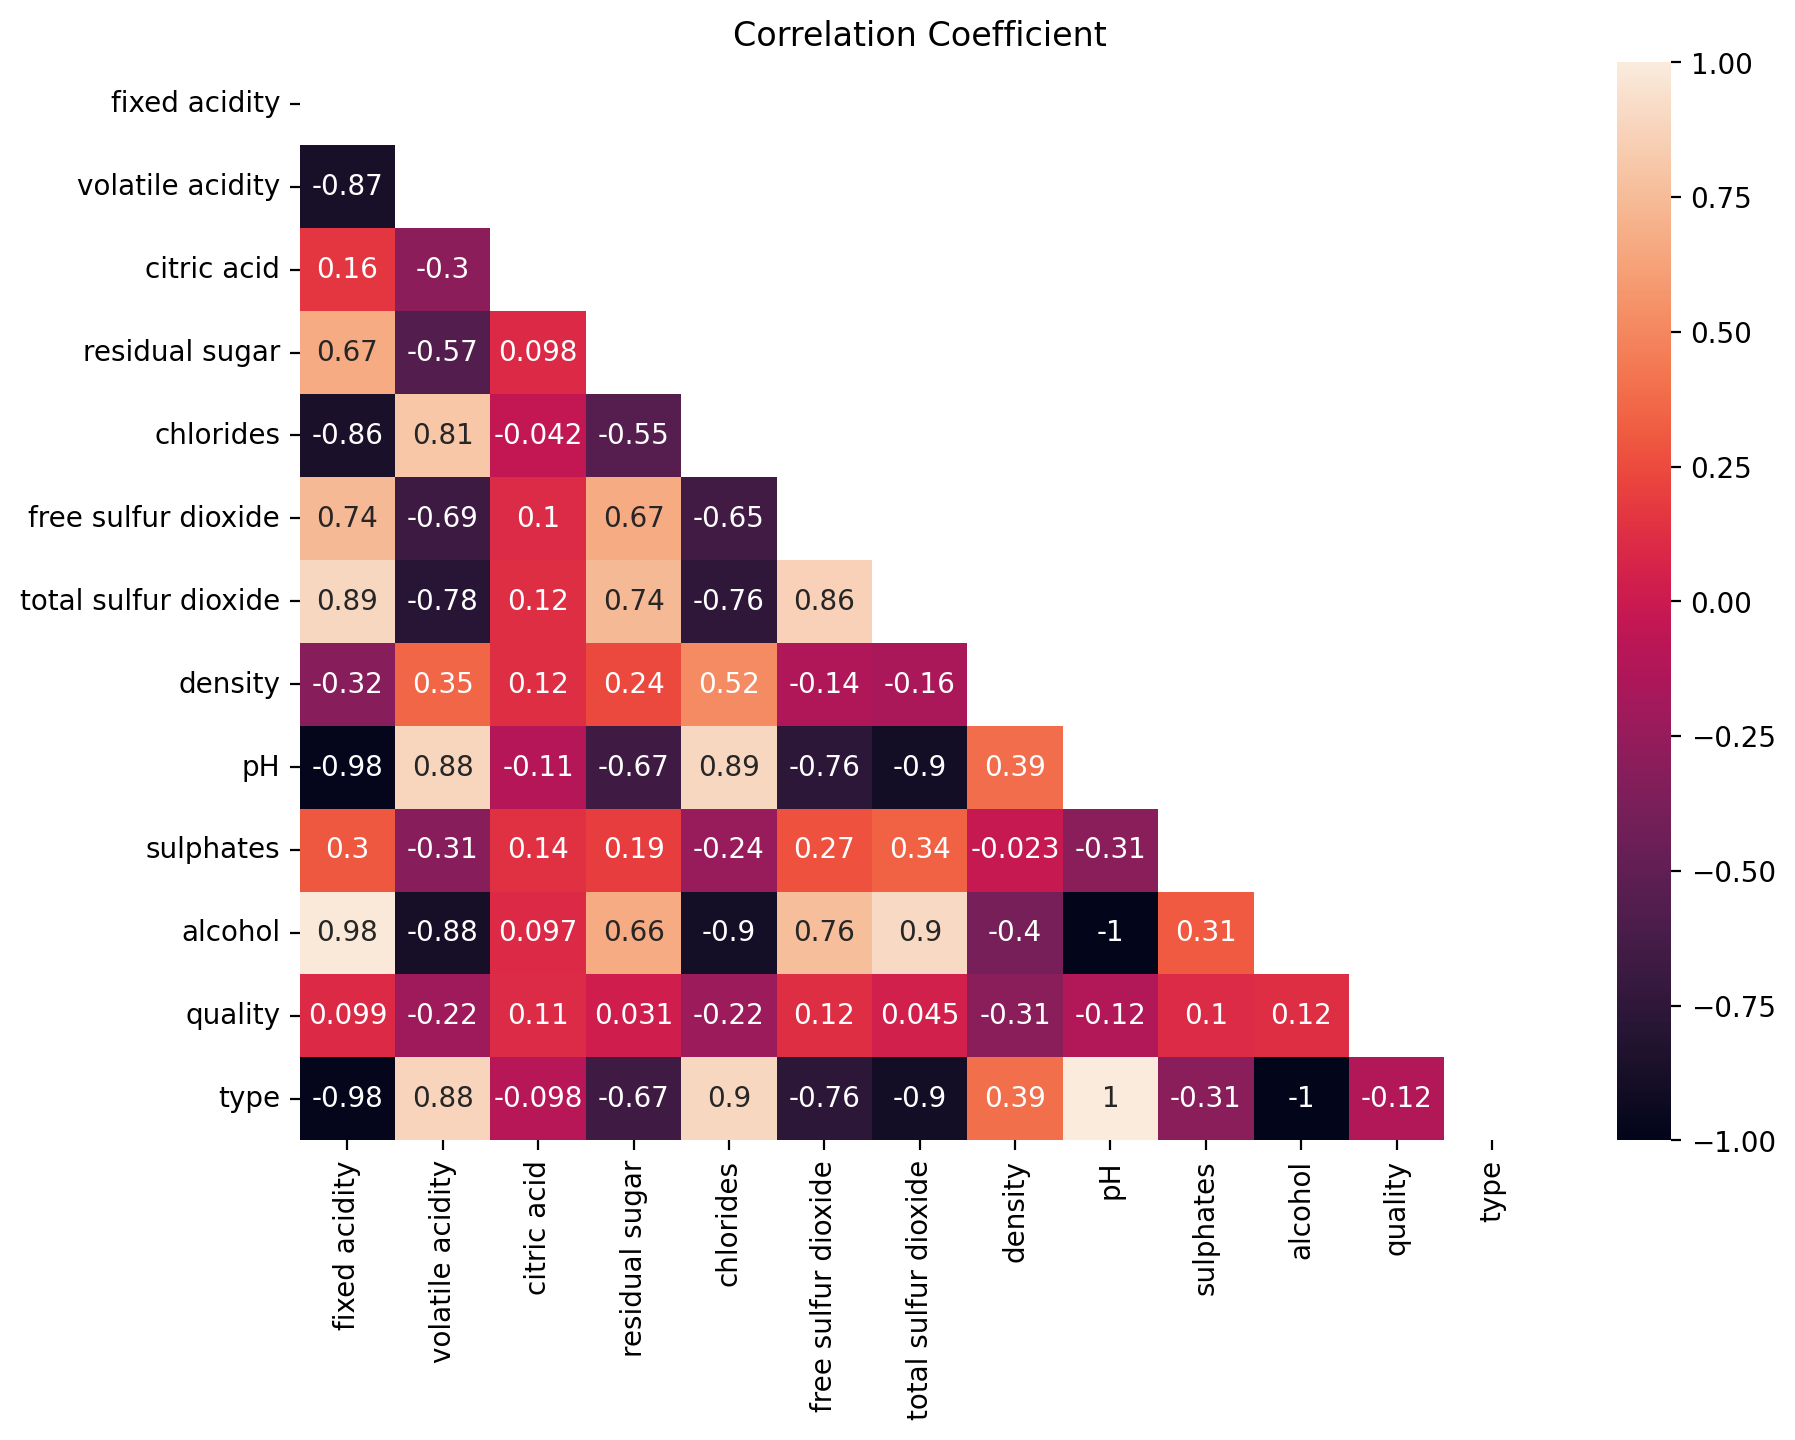

In [4]:
plt.figure(figsize = (10,7))

mask = np.triu(np.ones_like(df.corr(), dtype = bool))

sns.heatmap(df.corr(), annot = True, mask = mask, vmin = -1, vmax = 1)
plt.title('Correlation Coefficient')
plt.show()

### Variable Inflation Factor

In [15]:
def cal_vif(df):

    d_ = add_constant(df)
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(d_.values, i + 1) for i in range(len(df.columns))]
    vif_data.sort_values(by = ["VIF"], inplace = True, ascending = False)
    
    return vif_data

In [16]:
d = df.drop(columns = ["type", "quality"])
cal_vif(d)

,feature,VIF
10,alcohol,1441.899448
8,pH,1355.959802
0,fixed acidity,28.739811
6,total sulfur dioxide,11.249402
4,chlorides,6.980826
1,volatile acidity,5.995035
3,residual sugar,4.787268
7,density,4.427466
5,free sulfur dioxide,4.153243
2,citric acid,1.618318


Remove `alcohol`

In [17]:
d = df.drop(columns = ["type", "quality", "alcohol"])
cal_vif(d)

,feature,VIF
8,pH,49.221309
0,fixed acidity,28.211121
6,total sulfur dioxide,11.186047
4,chlorides,6.738881
1,volatile acidity,5.994990
3,residual sugar,4.683744
5,free sulfur dioxide,4.153211
7,density,4.054838
2,citric acid,1.412690
9,sulphates,1.187538


Remove `pH`

In [18]:
d = df.drop(columns = ["type", "quality", "alcohol", "pH"])
cal_vif(d)

,feature,VIF
0,fixed acidity,10.398484
6,total sulfur dioxide,9.949991
4,chlorides,6.626755
1,volatile acidity,5.377494
3,residual sugar,4.235252
5,free sulfur dioxide,4.151153
7,density,3.294754
2,citric acid,1.345592
8,sulphates,1.179635


Remove `fixed acidity`

In [19]:
d = df.drop(columns = ["type", "quality", "alcohol", "pH", "fixed acidity"])
cal_vif(d)

,feature,VIF
5,total sulfur dioxide,7.064825
3,chlorides,5.739727
0,volatile acidity,4.696550
2,residual sugar,4.195439
4,free sulfur dioxide,3.991274
6,density,3.285463
1,citric acid,1.339874
7,sulphates,1.178352


## SequentialFeatureSelector

In [25]:
X = df.drop(columns = ["type", "quality"])
type = df["type"]
qua = df["quality"]

sfs = SFS(
    cv = 5,
    estimator = LogisticRegression(max_iter = int(1e6)),
    forward = True,
    floating = True,
    k_features = "best",
    scoring = "accuracy",
    n_jobs = -1,
    verbose = 0
)

## Type
sfs.fit(X, type)
print(sfs.k_feature_names_)
print(sfs.k_score_)

## Quality
sfs.fit(X, qua)
print(sfs.k_feature_names_)
print(sfs.k_score_)

('fixed acidity',)
1.0
('volatile acidity', 'citric acid', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates')
0.4426764967134482
